In [1]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import numpy as np
from tqdm import tqdm

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

In [3]:
cuda = torch.cuda.is_available()

In [4]:
use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor   if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor   if use_cuda else torch.ByteTensor
def convert_to_var(arr, astype='float32', add_dim=False):
    if add_dim:
        arr = np.array([arr])
    if astype == 'float32':
        v = Variable(FloatTensor(arr.astype(astype))) 
    else:
        v = Variable(LongTensor(arr.astype(astype)))
    return v

In [5]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size()[0], -1)

In [6]:
class VAE(nn.Module):
    def __init__(self, input_shape=(-1, 10),
                 latent_dim=2, n_samples=10,
                 fc_size=1024, num_layers=2):
        super(VAE, self).__init__()
        self.n_samples = n_samples
        self.input_shape = input_shape
        
        encoder_layers = []
        encoder_layers.append(nn.Linear(input_shape[-1], fc_size))
        encoder_layers.append(nn.ReLU())
        for i in range(1,num_layers):
            encoder_layers.append(nn.Linear(fc_size//2**(i-1), fc_size//2**i))
            encoder_layers.append(nn.ReLU())
        self.encoder = nn.Sequential(*encoder_layers)
            
        self.fc_mu = nn.Linear(fc_size//2**(num_layers-1), latent_dim)
        self.fc_logvar = nn.Linear(fc_size//2**(num_layers-1), latent_dim)
        
        decoder_layers = []
        decoder_layers.append(nn.Linear(latent_dim, fc_size//2**(num_layers-1)))
        decoder_layers.append(nn.ReLU())
        
        for i in range(num_layers-1):
            decoder_layers.append(nn.Linear(fc_size//2**(num_layers-1-i), fc_size//2**(num_layers-i-2)))
            decoder_layers.append(nn.ReLU())
        decoder_layers.append(nn.Linear(fc_size, 2*input_shape[1]))
        self.decoder = nn.Sequential(*decoder_layers)

    def encode(self, x):
        enc_out = self.encoder(x)
        return self.fc_mu(enc_out), self.fc_logvar(enc_out)

    def reparameterize(self, mu, logvar):
        if self.training:
            n_samples = self.n_samples
            batch_size = mu.shape[0]
            latent_dim = mu.shape[1]
            eps = np.random.randn(batch_size*latent_dim*n_samples)\
                                 .reshape((batch_size, n_samples, latent_dim))
            eps = convert_to_var(eps)
            std = logvar.mul(0.5).exp_()
            mu = mu.view(-1, 1, latent_dim)
            std = std.view(-1, 1, latent_dim)
            return mu + eps*std
        else:
            return mu

    def decode(self, z):
        dec_out = self.decoder(z)
        if len(dec_out.shape) == 3:
            dec_out = dec_out.view(-1, self.n_samples, self.input_shape[1], 2)
            probs = F.softmax(dec_out, dim=-1)
            log_probs = F.log_softmax(dec_out, dim=-1)
            recon_x = probs[:,:,:,1]
        else:
            dec_out = self.decoder(z)
            dec_out = dec_out.view(-1, self.input_shape[1], 2)
            probs = F.softmax(dec_out, dim=-1)
            log_probs = F.log_softmax(dec_out, dim=-1)   
            recon_x = probs[:,:,1]
        return recon_x, log_probs

    
    def forward(self, x):
        mu, logvar = self.encode(x.view(self.input_shape))
        z = self.reparameterize(mu, logvar)
        recon_x, log_probs = self.decode(z)
        return recon_x, log_probs, mu, logvar

In [7]:
def loss_function(log_probs, x, mu, logvar, n_samples=10):
    KLD = 0.5 * torch.mean(
                      torch.sum(mu.pow(2) + logvar.exp() - 1 - logvar, dim=1))
    
    if len(log_probs.shape)==4:
        x = x.view(-1, 1, x.shape[1]).clone()
        x = x.repeat(1, n_samples, 1)
        LL = torch.sum((1-x)*log_probs[:,:,:,0] + x * log_probs[:,:,:,1]) / (x.shape[0]*n_samples)
    else:
        LL = torch.sum((1-x)*log_probs[:,:,0] + x * log_probs[:,:,1]) / (x.shape[0])

    elbo = LL - KLD
    loss = -1 * elbo
    return  loss, LL, KLD

In [8]:
from IPython.display import clear_output
from tqdm import trange

# функция для итераций по минибатчам, из первого семинара
def iterate_minibatches(inputs, batchsize, shuffle=True):
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt]

In [9]:
from matplotlib.patches import Ellipse

colors = ['red', 'green', 'blue', 'orange', 'pink']
def plot_point_with_std(mu, std):
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, aspect='equal')

    e = Ellipse([0,0], 6, 6)
    e.set_alpha(0.75)
    e.set_facecolor('white')
    e.set_edgecolor('black')
    ax.add_artist(e)

    
    for i in range(len(mu)):
        e = Ellipse(mu[i], 6*std[i][0], 6*std[i][1])
        e.set_alpha(0.25)
        e.set_facecolor('gray')
        ax.add_artist(e)

        plt.plot(mu[i][0], mu[i][1], '.', markersize=15,
                 color=colors[i], alpha=0.8)
    plt.grid()
    plt.title('title')
    plt.xlim((-4,4))
    plt.ylim((-4,4))

In [10]:
def plot_learning_history_with_pgs(logs, pgs, filename=None):
    
    ll_log, kld_log = logs[0], logs[1]
    
    plt.figure(figsize=(15, 5))
    linewidth = 4
    
    plt.subplot(1, 3, 1)
    plt.plot(ll_log)
    plt.title('LL')
    
    plt.subplot(1, 3, 2)
    plt.plot(kld_log)
    plt.title('KL')
    
    plt.subplot(1, 3, 3)
    plt.plot(pgs)
    plt.axhline(y=0, color='r', linewidth=5)
    plt.ylim(-1, 5)
    plt.title('PG')
    
    plt.grid()
    
    if filename is not None:
        plt.savefig(filename)
        plt.close()

In [11]:
dim = 50
num_classes = 5

In [12]:
def get_one_hot_object(obj_class, dim, num_classes):
    x = np.zeros(dim)
    x[:(dim//num_classes) * (obj_class+1)] = 1
    return x

# Онлайн-обучение

### Стационарные данные

In [13]:
def get_obj_log_prob(model, obj, return_loss=False):
    x = np.array([obj])
    probs, log_probs, mu, logvar = model(convert_to_var(x))
    
    if return_loss:
        loss, ll, kld = loss_function(log_probs, convert_to_var(x), mu, logvar, model.n_samples)

    log_probs = log_probs.data.numpy()[0].mean(axis=0)
    log_probs = log_probs[np.arange(dim), obj.astype('int64')]
    obj_log_prob = log_probs.sum()

    if return_loss:
        return obj_log_prob, loss, ll, kld
    else:
        return obj_log_prob

In [14]:
def plot_all_lls(lls):
    n = len(lls)
    plt.figure(figsize=(4*n,4))
    for i in range(len(lls)):
        plt.subplot(1,n,i+1)
        plt.plot(lls[i],label='class {}'.format(i+1))
        plt.legend(loc='lower right')
        plt.grid()
        plt.title("LL")

In [26]:
def run(shedule, X_test,
       fc_size=1024, num_layers=2, use_adam=True,
       lr=0.0001, momentum=0.9, weight_decay=0, eps=1e-8, centered=False,
       betas=(0.9, 0.99),
       img_name=None):
    
    np.random.seed(11)

    model = VAE(latent_dim=2, input_shape=(-1, dim),
                n_samples=1000, fc_size=fc_size, num_layers=num_layers)

    if use_adam:
        optimizer = optim.Adam(model.parameters(), lr=lr, betas=betas,
                               weight_decay=weight_decay, eps=eps)
    else:
        optimizer = optim.RMSprop(model.parameters(), lr=lr, momentum=momentum,
                                  weight_decay=weight_decay, eps=eps, centered=centered)

    pgs = [] # should be always positive
    total_loss_gains = [] #should be always negative
    kl_gains = [] 
    
    train_logs = [[] for _ in range(2)]
    num_steps = int(1e3)
    
    all_log_probs = [[] for _ in range(len(X_test))]
    
    for t in range(len(shedule)):
        
        ##################################################################################
        model.train()
        cur_class = shedule[t]            
        obj = get_one_hot_object(cur_class, dim, num_classes)

        log_prob_before, loss, ll, kld = get_obj_log_prob(model, obj, return_loss=True)

        train_logs[0].append(ll.data.numpy()[0])
        train_logs[1].append(kld.data.numpy()[0])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        log_prob_after, loss_next, ll_next, kld_next = get_obj_log_prob(model, obj, return_loss=True)

        pg = log_prob_after - log_prob_before
        pgs.append(pg)
        
        loss_gain = loss_next.data.numpy()[0]-loss.data.numpy()[0]
        total_loss_gains.append(loss_gain)
        
        kld_gain = kld_next.data.numpy()[0] - kld.data.numpy()[0]
        kl_gains.append(kld_gain)
        ##################################################################################
        for i, obj in enumerate(X_test):
            log_prob = get_obj_log_prob(model, obj, return_loss=False)
            all_log_probs[i].append(log_prob)
                
    if img_name is not None:
        plot_learning_history_with_pgs(train_logs, pgs, filename=img_name)
    else:
        plot_learning_history_with_pgs(train_logs, pgs)
        plot_all_lls(all_log_probs)
    
    pgs = np.array(pgs)
    pct = (pgs < 0).mean()
    
    lls = np.array(train_logs[0])
    mean_last_ll = lls[-10:].mean()
    
    return mean_last_ll, pct, all_log_probs, pgs, total_loss_gains, kl_gains

In [18]:
x_shedule = [np.random.randint(5) for _ in range(1000)]

In [19]:
X_test = []
for obj_class in np.unique(x_shedule):
    obj = get_one_hot_object(obj_class, dim, num_classes)
    X_test.append(obj)

In [20]:
np.array(X_test).sum(axis=1)

array([10., 20., 30., 40., 50.])

CPU times: user 7min 43s, sys: 4.6 s, total: 7min 48s
Wall time: 3min 39s


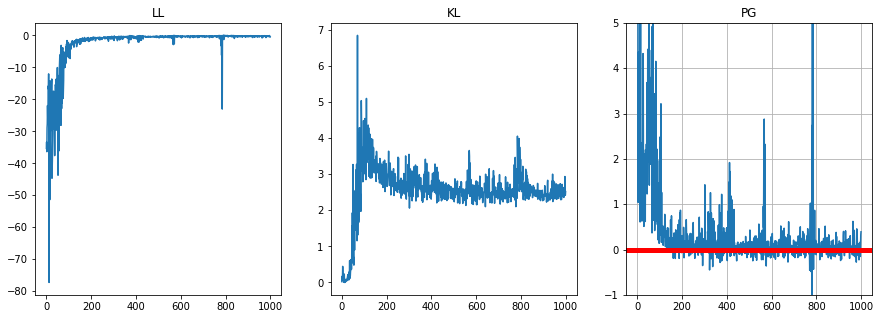

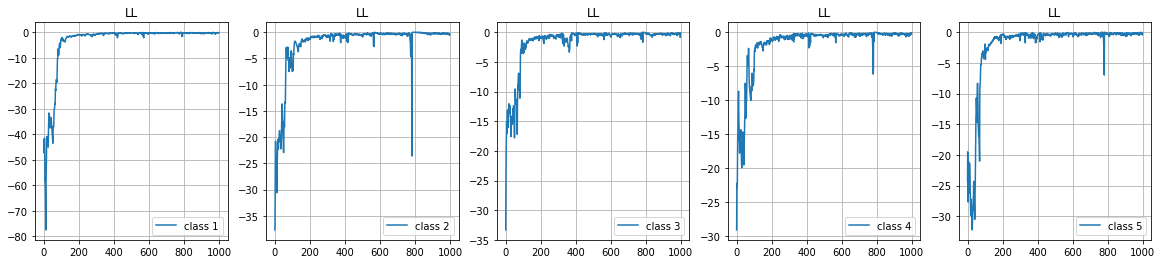

In [27]:
%%time
results = run(x_shedule,X_test,
              fc_size=1024, num_layers=2,
              lr=0.0001, momentum=0.5, use_adam=False)

In [28]:
mean_last_ll, pct, all_log_probs, pgs, total_loss_gains, kl_gains = results

In [29]:
pgs = np.array(pgs)
total_loss_gains=np.array(total_loss_gains)
kl_gains = np.array(kl_gains)

### Рассмотрим все варианты знаков

In [54]:
for i in [-1,1]:
    for j in [-1,1]:
        for k in [-1,1]:
            print(i,j,k)

-1 -1 -1
-1 -1 1
-1 1 -1
-1 1 1
1 -1 -1
1 -1 1
1 1 -1
1 1 1


In [ ]:
# Loss = -1*LL + KLD

#(-1,-1,-1) - LL уменьш, Loss уменьш, KL уменьш => -1*LL увел меньше, чем KL уменьш - ОК - НОРМА ДЛЯ МОДЕЛИ(159).
#(-1,-1,1) - LL уменьш, Loss уменьш, KL увел => -1*LL увел, KL увел - не ОК -------------------------------.

#(-1,1,-1) - LL уменьш, Loss увел, KL уменьш => -1*LL увел, KL уменьш - ОК - НЕ НОРМА ДЛЯ МОДЕЛИ (135).
#(-1,1, 1) - LL уменьш, Loss увел, KL увел => -1*LL увел, KL увел - ОК НЕ НОРМА ДЛЯ МОДЕЛИ (28).

#(1,-1,-1) - LL увел, Loss уменьш, KL уменьш - ОК (260)
#(1,-1,1) -  LL увел, Loss уменьш, KL увел - ОК (388)

#(1,1,-1) - LL увел, Loss увел, KL уменьш - не ОК------------
#(1,1,1) - LL увел, Loss увел, KL увел - ОК (30)

In [45]:
from collections import defaultdict
n = len(pgs)
cnt = defaultdict(int)

for i in range(n):
    pg_sign = 1 if pgs[i]>=0 else -1
    loss_sign = 1 if total_loss_gains[i]>=0 else -1
    kl_sign = 1 if kl_gains[i] >= 0 else -1
    
    cnt[(pg_sign, loss_sign, kl_sign)] += 1

In [46]:
cnt

defaultdict(int,
            {(-1, -1, -1): 159,
             (-1, 1, -1): 135,
             (-1, 1, 1): 28,
             (1, -1, -1): 260,
             (1, -1, 1): 388,
             (1, 1, 1): 30})

In [56]:
(pgs<0).sum()

322

In [57]:
135+159+28

322

### Вывод:
Из 32% случаев PG<0 в 16% случаев засчет уменьшения LL уменьшается KL и в целом уменьшается Loss на объекте.
Еще в 13% вместе с LL также уменьшается KL, но Loss в итоге все равно возрастает. И только в 3% уменьшение LL происходит одновременно с увеличением общего Loss'a и увеличением KL.

Таким образом, можно полностью оправдать отрицательный PG в 16% случаев, и еще в 13% предположить, что модель делала ставку на уменьшение LL ради уменьшения KL, но в итоге вышло так, что общий Loss все-таки вырос.

На основании этих наблюдений можно сделать предположение о том, что перенормировка суммарных составляющих оптимизируемой функции потерь может привести к уменьшению доли шагов оптимизации, при которых получается PG<0.
